### Playing with the student database in mongoDB

Here, let us try to understand the student database created in the mongoDB using the mongo queries.

In [6]:
import math
import numpy as np
import pandas as pd
from pprint import pprint
import pymongo

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Mongo client
client = pymongo.MongoClient("mongodb://localhost:27017")

In [13]:
# connecting to the "Student" database 
db = client["student"]

In [14]:
client.list_database_names()

['MovieLens', 'admin', 'config', 'local', 'practice', 'student', 'terrorism']

### mongo queries 

In [18]:
# we have two collections in the student database
db.list_collection_names()

['student_mat', 'student_por']

In [19]:
# total number of records in the collection
db.student_por.count_documents({})

649

In [20]:
# total number of records in the collection
db.student_mat.count_documents({})

395

In [21]:
def find_students():
    # find(filter, project)
    cursor = db.student_por.find({"absences" : {"$gte" : 10}, "G3": {"$gte": 15}}, 
                                 {"_id" : 0, "school" : 1, "sex" : 1, "G3" : 1})
    # printing the selections
    pprint([entry for entry in cursor])

In [22]:
find_students()

[{'G3': 18, 'school': 'GP', 'sex': 'M'},
 {'G3': 16, 'school': 'GP', 'sex': 'F'},
 {'G3': 16, 'school': 'GP', 'sex': 'F'},
 {'G3': 17, 'school': 'GP', 'sex': 'F'},
 {'G3': 15, 'school': 'GP', 'sex': 'F'},
 {'G3': 18, 'school': 'GP', 'sex': 'M'},
 {'G3': 17, 'school': 'GP', 'sex': 'F'}]


In [23]:
cursor = db.student_por.find({"Pstatus": 'A', "G3": {"$gte": 10}})
# number of cases
len([record for record in cursor])

68

In [25]:
# Parents are living together or apart
# its effect on the student's performance
def plot_effect_bar(feature):
    levels = db.student_por.distinct(feature)
    counts = []
    for case in levels:
        cursor = db.student_por.find({feature: case, "G3": {"$gte": 15}})
        counts.append(len([record for record in cursor]))
    plt.bar(levels, counts);
    plt.xlabel(feature);
    plt.title('%s based performance' % feature);

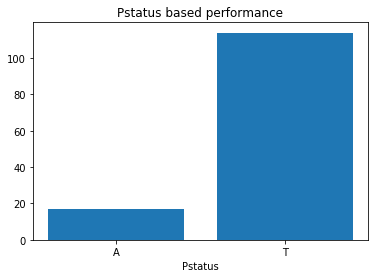

In [26]:
plot_effect_bar("Pstatus")

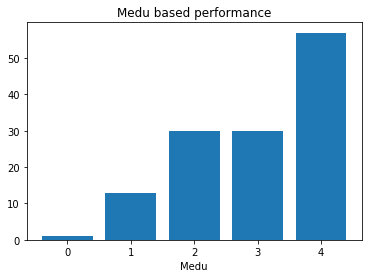

In [27]:
# based on the education level of Mother
plot_effect_bar("Medu")

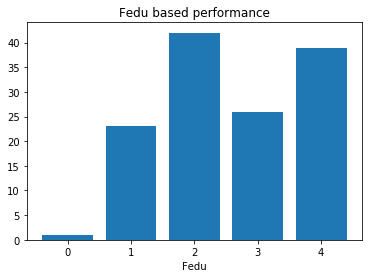

In [28]:
# based on the Education level of Father
plot_effect_bar("Fedu")

Seems there is a clear relation on the peformance of the students based on the education level of mother more than that of father.

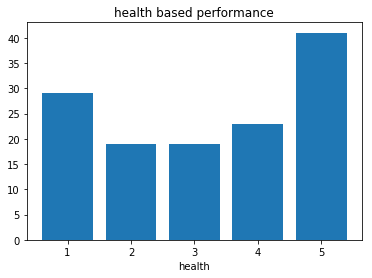

In [29]:
plot_effect_bar("health")

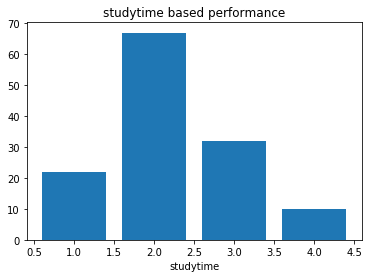

In [30]:
plot_effect_bar("studytime")

#### aggregate method

In [40]:
# returns students info who were absent for many days 
# but still performed good
def genius_students():
    genius = db.student_por.aggregate(
           [{ "$match": {"absences": {"$gte" : 10}, "G3": {"$gte": 15}}}, 
            { "$project" : { "From" : {"$concat" : ["$school", "-", "$sex"]},
                             "_id": 0,
                              "G1" : "$G1", "G2" : "$G2", "G3" : "$G3",
                              "totalScore" : {"$add" : ["$G1", "$G2", "$G3"]},
                              "percentage" : {"$divide" : [{"$add" : ["$G1", "$G2", "$G3"]}, 0.6]}
                             }},
            { "$sort" : {"totalScore" : 1}},
           ]
        )
    students = [stu for stu in genius]
    print('Number of cases: ', len(students))
    print("\n===printing some===")
    for i in range(len(students)):
        pprint(students[i])
        if i > 2: break

In [34]:
genius_students()

Number of cases:  7

===printing some===
{'From': 'GP-F',
 'G1': 12,
 'G2': 15,
 'G3': 15,
 'percentage': 70.0,
 'totalScore': 42}
{'From': 'GP-F',
 'G1': 14,
 'G2': 15,
 'G3': 16,
 'percentage': 75.0,
 'totalScore': 45}
{'From': 'GP-F',
 'G1': 15,
 'G2': 14,
 'G3': 17,
 'percentage': 76.66666666666667,
 'totalScore': 46}
{'From': 'GP-F',
 'G1': 16,
 'G2': 16,
 'G3': 16,
 'percentage': 80.0,
 'totalScore': 48}


In [124]:
# students who travelled, did romance, 
# spent freetime and still performed well
def with_fun(n):
    cursor = db.student_por.aggregate([
                { "$match" : {"traveltime" : {"$gt" : 0}, "romantic" : "yes", "freetime" : {"$gt" : 0}, "G3" : {"$gt" : 15}}},
                { "$project" : {"_id": 0, "traveltime" : "$traveltime", "romantic" : "$romantic", "freetime" : "$freetime", 
                                "G3" : "$G3"}},
             ])
    # printing n of those students info
    i = 0
    for student in cursor:
        pprint(student)
        i += 1
        if i == n: break

In [125]:
with_fun(5)

{'G3': 16, 'freetime': 5, 'romantic': 'yes', 'traveltime': 4}
{'G3': 16, 'freetime': 4, 'romantic': 'yes', 'traveltime': 1}
{'G3': 18, 'freetime': 2, 'romantic': 'yes', 'traveltime': 1}
{'G3': 17, 'freetime': 4, 'romantic': 'yes', 'traveltime': 1}
{'G3': 18, 'freetime': 3, 'romantic': 'yes', 'traveltime': 2}


In [ ]:
"$project": {"_id": "total_score", "count": "count"}

In [121]:
# aggregate with group
def totalscores_distribution(plot=False, show=False, limit=None):
    # how many to show?
    if not limit:
        limit = 5
    cursor = db.student_por.aggregate([
            # total_score = G1 + G2 + G3
            {
                "$group": {
                    "_id": {"$sum": ["$G1",  "$G2", "$G3"]},
                    "count": {"$sum": 1}
                        }
            }, {
                "$project": {"_id": 0, "count": "$count", "total_score": "$_id",}
            }, {
                "$sort": {"total_score": -1}  # sorting by total_score
            }
        ])
    
    if plot:
        scores = []
        counts = []
        for item in cursor:
            scores.append(item['total_score'])
            counts.append(item['count'])
        plt.bar(scores, counts)
        plt.xlabel('total score')
        plt.ylabel('count');
        plt.title('total score distribution');
        
    # rather print some to see the sorted total scores
    if show:
        i = 0
        for record in cursor:
            pprint(record)
            i += 1
            if i > limit: break

In [123]:
# few (limit=10) top scores and number of students
totalscores_distribution(plot=False, show=True, limit=10)

{'count': 1, 'total_score': 56}
{'count': 6, 'total_score': 54}
{'count': 5, 'total_score': 53}
{'count': 7, 'total_score': 52}
{'count': 7, 'total_score': 51}
{'count': 2, 'total_score': 50}
{'count': 7, 'total_score': 49}
{'count': 12, 'total_score': 48}
{'count': 12, 'total_score': 47}
{'count': 13, 'total_score': 46}
{'count': 14, 'total_score': 45}


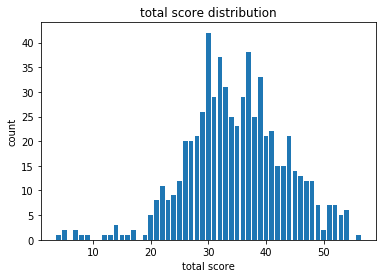

In [120]:
totalscores_distribution(plot=True, show=False, limit=10)